<a href="https://colab.research.google.com/github/7amzaGH/5G-Network-Slicing-Optimization/blob/main/code/notebooks/smart_city.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **5G Network Slicing Optimization using ILP**
# **Author: Hamza Ghitri**



In [1]:
!pip install pulp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 33.1 MB/s eta 0:00:00


# **Main code**

In [5]:

from pulp import LpMaximize, LpProblem, LpVariable, lpSum, value

# -------------------------------
# Define data
# -------------------------------
slices = ["eMBB", "uRLLC", "mMTC", "PublicSafety", "VideoSurveillance"]
links = ["fiber", "microwave", "mmwave", "sub6ghz"]
time_slots = list(range(1, 25))  # 24 hours

# Link capacities (Gbps)
capacity = {
    "fiber": 10000,      # 10 Gbps
    "microwave": 2000,   # 2 Gbps
    "mmwave": 5000,      # 5 Gbps
    "sub6ghz": 3000      # 3 Gbps
}

# Realistic hourly demands (Mbps) - varies by time of day
demand = {}

# eMBB (Mobile Broadband) - peaks during commute hours
embb_pattern = [200, 150, 100, 80, 100, 300, 800, 1200, 1000, 600, 500, 600,
                700, 650, 700, 900, 1500, 1800, 1400, 900, 600, 400, 300, 250]

# uRLLC (Autonomous vehicles) - peaks during rush hours
urllc_pattern = [50, 30, 20, 20, 40, 150, 400, 600, 500, 300, 250, 280,
                 300, 280, 300, 350, 700, 800, 600, 350, 200, 120, 80, 60]

# mMTC (IoT sensors) - constant with slight variations
mmtc_pattern = [100, 95, 90, 88, 90, 100, 110, 120, 115, 105, 100, 105,
                110, 108, 110, 115, 125, 130, 120, 110, 105, 102, 100, 98]

# Public Safety - low baseline, spikes during emergencies
public_safety_pattern = [50, 50, 50, 50, 50, 60, 70, 80, 75, 65, 60, 65,
                         70, 68, 70, 75, 85, 90, 85, 75, 65, 60, 55, 50]

# Video Surveillance - higher during night/security hours
video_pattern = [300, 350, 400, 450, 400, 350, 280, 250, 230, 220, 210, 215,
                 220, 215, 220, 240, 260, 280, 300, 350, 380, 360, 340, 320]

# Distribute demands across links (different slices prefer different links)
for t in time_slots:
    idx = t - 1

    # eMBB prefers high-capacity fiber and mmwave
    demand[("eMBB", "fiber", t)] = int(embb_pattern[idx] * 0.5)
    demand[("eMBB", "mmwave", t)] = int(embb_pattern[idx] * 0.3)
    demand[("eMBB", "sub6ghz", t)] = int(embb_pattern[idx] * 0.2)
    demand[("eMBB", "microwave", t)] = 0

    # uRLLC needs low-latency (fiber, mmwave)
    demand[("uRLLC", "fiber", t)] = int(urllc_pattern[idx] * 0.6)
    demand[("uRLLC", "mmwave", t)] = int(urllc_pattern[idx] * 0.4)
    demand[("uRLLC", "sub6ghz", t)] = 0
    demand[("uRLLC", "microwave", t)] = 0

    # mMTC uses all links (massive devices, distributed)
    demand[("mMTC", "fiber", t)] = int(mmtc_pattern[idx] * 0.3)
    demand[("mMTC", "microwave", t)] = int(mmtc_pattern[idx] * 0.2)
    demand[("mMTC", "mmwave", t)] = int(mmtc_pattern[idx] * 0.2)
    demand[("mMTC", "sub6ghz", t)] = int(mmtc_pattern[idx] * 0.3)

    # Public Safety - prioritizes reliable fiber
    demand[("PublicSafety", "fiber", t)] = int(public_safety_pattern[idx] * 0.7)
    demand[("PublicSafety", "microwave", t)] = int(public_safety_pattern[idx] * 0.3)
    demand[("PublicSafety", "mmwave", t)] = 0
    demand[("PublicSafety", "sub6ghz", t)] = 0

    # Video Surveillance - high bandwidth (fiber, sub6ghz)
    demand[("VideoSurveillance", "fiber", t)] = int(video_pattern[idx] * 0.6)
    demand[("VideoSurveillance", "sub6ghz", t)] = int(video_pattern[idx] * 0.4)
    demand[("VideoSurveillance", "mmwave", t)] = 0
    demand[("VideoSurveillance", "microwave", t)] = 0
# -------------------------------
# Define model
# -------------------------------
model = LpProblem("5G_Network_Slicing_Optimization", LpMaximize)

# Decision variable: x[slice, link, t] = 1 if bandwidth allocated, 0 otherwise
x = LpVariable.dicts("x", (slices, links, time_slots), cat="Binary")

# Objective: maximize total allocated bandwidth across all time slots
model += lpSum(
    demand.get((s, l, t), 0) * x[s][l][t]
    for s in slices
    for l in links
    for t in time_slots
), "TotalBandwidth"

# Constraints: total usage per link per time slot <= capacity
for l in links:
    for t in time_slots:
        model += (
            lpSum(demand.get((s, l, t), 0) * x[s][l][t] for s in slices) <= capacity[l],
            f"Capacity_{l}_T{t}"
        )

# Fairness constraint: each slice must get at least one allocation per time slot
for s in slices:
    for t in time_slots:
        model += (
            lpSum(x[s][l][t] for l in links) >= 1,
            f"Fairness_{s}_T{t}"
        )

# -------------------------------
# Solve
# -------------------------------
print("=" * 50)
print("5G NETWORK SLICING OPTIMIZATION")
print("=" * 50)
print("\nSolving the model...\n")

status = model.solve()

# -------------------------------
# Results
# -------------------------------
print("Status:", "Optimal" if status == 1 else "Not Optimal")
print(f"Solver: {model.solver}")
print("\n" + "=" * 50)
print("ALLOCATION RESULTS")
print("=" * 50)

total_bandwidth = 0
for t in time_slots:
    print(f"\n Time Slot {t}:")
    print("-" * 40)
    for s in slices:
        allocated = []
        for l in links:
            if value(x[s][l][t]) == 1:
                bw = demand.get((s, l, t), 0)
                allocated.append(f"{l}: {bw} Mbps")
                total_bandwidth += bw
        if allocated:
            print(f"  {s:10} → {', '.join(allocated)}")

print("\n" + "=" * 50)
print(f" Total Optimized Bandwidth: {total_bandwidth} Mbps")
print(f" Objective Value: {value(model.objective)}")
print("=" * 50)

5G NETWORK SLICING OPTIMIZATION

Solving the model...

Status: Optimal
Solver: <pulp.apis.coin_api.PULP_CBC_CMD object at 0x7e3a99893d70>

ALLOCATION RESULTS

 Time Slot 1:
----------------------------------------
  eMBB       → fiber: 100 Mbps, microwave: 0 Mbps, mmwave: 60 Mbps, sub6ghz: 40 Mbps
  uRLLC      → fiber: 30 Mbps, microwave: 0 Mbps, mmwave: 20 Mbps, sub6ghz: 0 Mbps
  mMTC       → fiber: 30 Mbps, microwave: 20 Mbps, mmwave: 20 Mbps, sub6ghz: 30 Mbps
  PublicSafety → fiber: 35 Mbps, microwave: 15 Mbps, mmwave: 0 Mbps, sub6ghz: 0 Mbps
  VideoSurveillance → fiber: 180 Mbps, microwave: 0 Mbps, mmwave: 0 Mbps, sub6ghz: 120 Mbps

 Time Slot 2:
----------------------------------------
  eMBB       → fiber: 75 Mbps, microwave: 0 Mbps, mmwave: 45 Mbps, sub6ghz: 30 Mbps
  uRLLC      → fiber: 18 Mbps, microwave: 0 Mbps, mmwave: 12 Mbps, sub6ghz: 0 Mbps
  mMTC       → fiber: 28 Mbps, microwave: 19 Mbps, mmwave: 19 Mbps, sub6ghz: 28 Mbps
  PublicSafety → fiber: 35 Mbps, microwave: 15 M

# Dashboard charts of all allocations

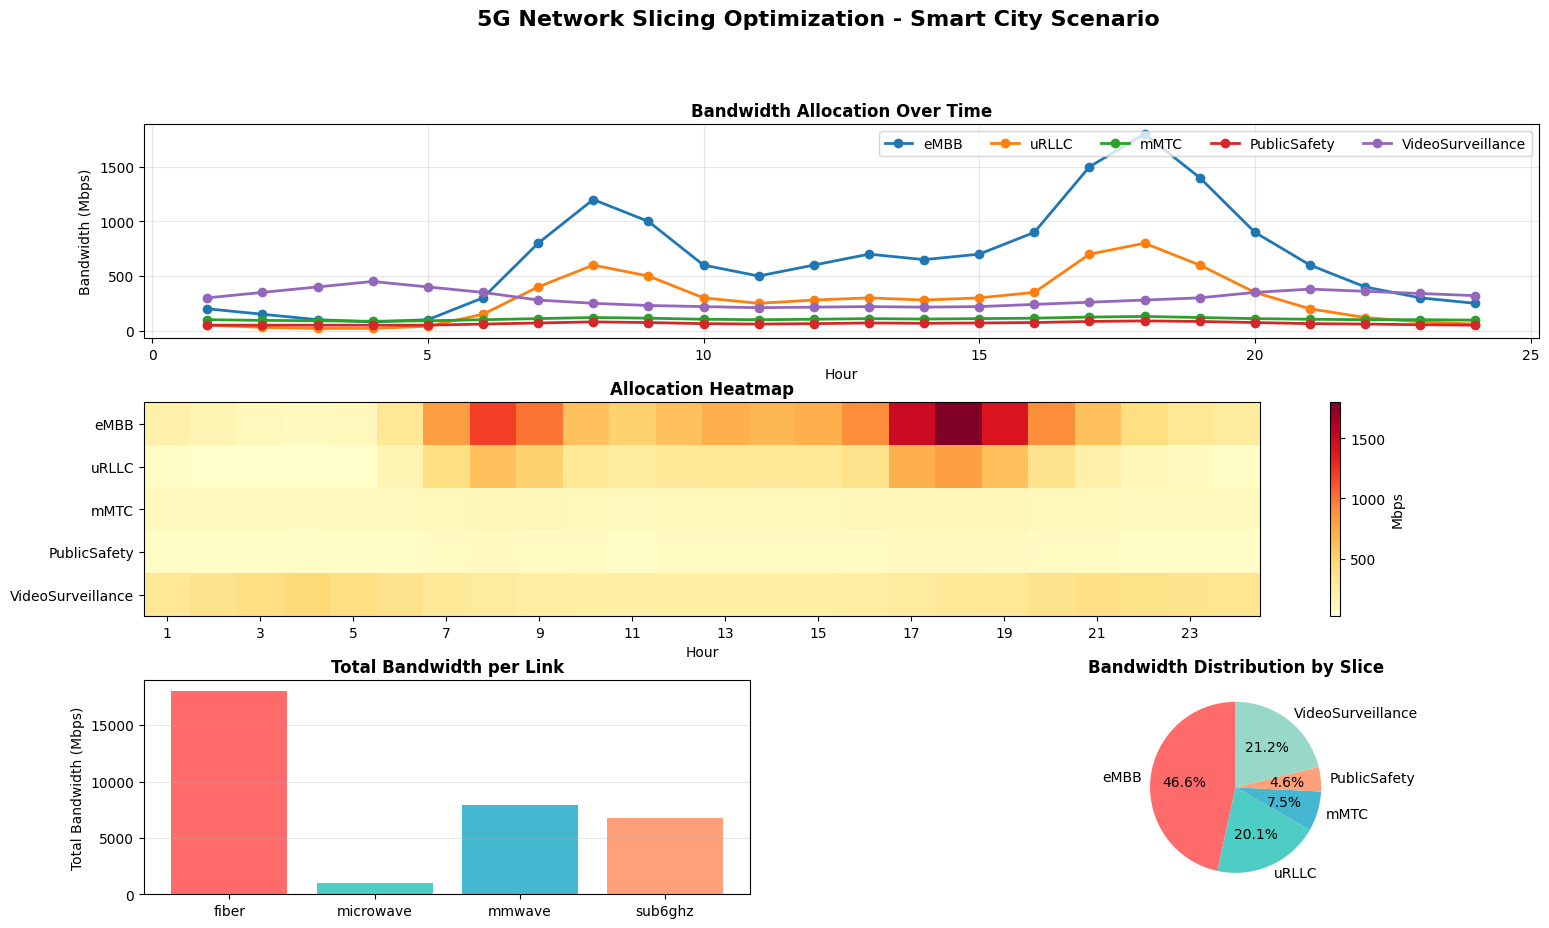

In [12]:
fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# 1. Time series
ax1 = fig.add_subplot(gs[0, :])
for s in slices:
    ax1.plot(time_slots, slice_time_data[s], marker='o', linewidth=2, label=s)
ax1.set_title('Bandwidth Allocation Over Time', fontsize=12, fontweight='bold')
ax1.set_xlabel('Hour')
ax1.set_ylabel('Bandwidth (Mbps)')
ax1.legend(loc='upper right', ncol=5)
ax1.grid(True, alpha=0.3)

# 2. Heatmap
ax2 = fig.add_subplot(gs[1, :])
im = ax2.imshow(heatmap_data, cmap='YlOrRd', aspect='auto')
ax2.set_yticks(range(len(slices)))
ax2.set_yticklabels(slices)
ax2.set_xticks(range(0, len(time_slots), 2))
ax2.set_xticklabels(range(1, 25, 2))
ax2.set_title('Allocation Heatmap', fontsize=12, fontweight='bold')
ax2.set_xlabel('Hour')
plt.colorbar(im, ax=ax2, label='Mbps')

# 3. Link utilization
ax3 = fig.add_subplot(gs[2, 0])
link_totals = [sum(link_time_data[l]) for l in links]
ax3.bar(links, link_totals, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A'])
ax3.set_title('Total Bandwidth per Link', fontsize=12, fontweight='bold')
ax3.set_ylabel('Total Bandwidth (Mbps)')
ax3.grid(axis='y', alpha=0.3)

# 4. Slice distribution pie
ax4 = fig.add_subplot(gs[2, 1])
slice_totals = [sum(slice_time_data[s]) for s in slices]
ax4.pie(slice_totals, labels=slices, autopct='%1.1f%%', startangle=90,
        colors=['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8'])
ax4.set_title('Bandwidth Distribution by Slice', fontsize=12, fontweight='bold')

plt.suptitle('5G Network Slicing Optimization - Smart City Scenario',
             fontsize=16, fontweight='bold', y=0.995)

plt.savefig('dashboard_complete.png', dpi=300, bbox_inches='tight')
plt.show()